# Evaluation of methods for converting enthalpy to temperature
This notebook compares different methods for the conversion of enthalpy to temperature.
The evaluation is performed in terms of time effort and accuracy.

The following methods are considered:
- **Newton (NEW)**
  
    _Newton's_ method is an iterative algorithm for finding the root of a function $f(x)$.  
    The iterative formula to update the guess root is:

    $$
    x_{n+1} = x_{n} - \frac{f(x_{n})}{f'(x_{n})},
    $$

    where subscrits $n$ and $n+1$ refer, in the order, to the old and new iterations. 

    To find the temperature $T_{i+1}$ corresponding to the known enthalpy rise $\Delta{h_{i, i+1}}$, 
    from the $i^{th}$ to the $(i+1)^{th}$ states, the root must be found for the following function:

    $$
    f(T_{i+1}) = \Delta{h_{i, i+1}} - \Delta{h}^*(T_{i+1}),
    $$

    where $\Delta{h}^*(T_{i+1})$ is the result of a correlation function specific for each material and expressed in terms of $T_{i+1}$.

    Thus, the iteration formula becomes:

    $$
    T_{i+1, n+1} = T_{i+1, n} + \frac{\Delta{h_{i,i+1} - \Delta{h}^*(T_{i+1, n})}}{c_p(T_{i+1, n})}.
    $$

- **_lbh15_**

    _lbh15_ (https://github.com/newcleo-dev-team/lbh15) is a Python-based library providing Lead, Bismuth and LBE thermophysical and thermochemical properties. Given a thermodynamic state (in this case defined by the temperature $T$, as the pressure is assumed to be equal to the atmospheric one), _lbh15_ implements the correlation provided by NEA Handbook (NEA (2024), Handbook on Lead-bismuth Eutectic Alloy and Lead Properties, Materials Compatibility, Thermal-hydraulics and Technologies – 2015 Edition, OECD Publishing, Paris) to find the corresponding $\Delta{h}(T)$, which is computed with respect to the melting state of the corresponding liquid metal. 

- **Table interpolation (TAB)**

    This method relies on the _NumPy_ function `interp()` to perform linear interpolations. It reads a dataset from a _csv_ file that reports the enthalpies for specific temperature values: enthalpy values are defined with respect to the melting temperature of the liquid metal and calculated with _lbh15_ (considered as the correct reference tool). 

- **Fitting polynomial (POLY)**
  
    A polynomial is built from the same dataset as that used in the method above, using the _NumPy_ functions `polyfit` and `polyval`.
    `polyval` is chosen because it is considered to be sufficiently efficient due to its use of the Horner scheme. 

## Application and comparison
The methods described above are implemented in the file _temp_from_h.py_, and imported in the following code section. 

Their accuracy and requested time effort are evaluated with the `eval_time` and `eval_accuracy` functions, imported from the file _time_and_accuracy.py_.

In [1]:
from temp_from_h import newton_method, lbh15_method, table_method, poly_method
from time_and_accuracy import eval_time, eval_accuracy, table_method_summary, \
    get_poly_results
from plots import plot_table_evaluation, plot_polynomium_results, \
    plot_accuracy_comparison
from _commons import DB_SIZES, T_IN
import numpy as np 
from dassh import Material
from tabulate import tabulate
import os


MATERIAL: str = 'lead'
"""Material to be used"""
DB_PATH_PREFIX: str = f"{MATERIAL}_"
"""Prefix for the path to the data files"""
DB_PATH_SUFFIX: str = ".csv"
"""Suffix for the path to the data files"""
DATA_FOLDER: str = os.path.join('data', MATERIAL)
"""Folder containing the data files"""
reference = np.genfromtxt(os.path.join(DATA_FOLDER, f'{MATERIAL}_ref.csv'), 
                          delimiter=',')
coolant = Material(MATERIAL, T_IN)

In the following, the _TAB_ method is first examined. Datasets of varying sizes (ranging from 1000 to 5000 data points) are used as the basis for interpolation. For each dataset, the accuracy then is estimated against the reference dataset contained in _lead_ref.csv_, which is constructed using _lbh15_ and contains 5000 temperature-enthalpy couples. 
The _POLY_ method is then analyzed by constructing polynomials of varying degrees to determine which provides the best fit.

Once the optimal dataset for the _TAB_ method and the best polynomial for the _POLY_ method have been identified, the comparison is extended to the _NEW_ and _lbh15_ methods, first in terms of time effort and then of accuracy.


> The analysis reported in this notebook is performed with **lead**. For other materials refer to the other notebooks:  _sodium_results.ipynb_, _nak_results.ipynb_, _lbe_results.ipynb_, _bismuth_results.ipynb_.


## TAB method analysis
The accuracy of the _TAB_ method depends on the depth of the dataset used for interpolation. Higher densities of data points are expected to lead to higher interpolation accuracy. To evaluate how accuracy is influenced by the amount of data, different datasets (collecting from 1000 to 5000 temperature-enthalpy couples) have been created and are compared in terms of time effort and accuracy against a reference dataset of 5000 points. The 5000-point datasets used for building the interpolation and for calculating the accuracy are different: temperature values are obtained over slightly different variation ranges.

In [9]:
results_table = {}
for s in DB_SIZES[MATERIAL]:
    path = DB_PATH_PREFIX + str(s) + DB_PATH_SUFFIX
    data_path = os.path.join(DATA_FOLDER, path)
    results_table[s] = table_method_summary(reference, data_path)

Below the resulting accuracy and time effort for `table_method`:

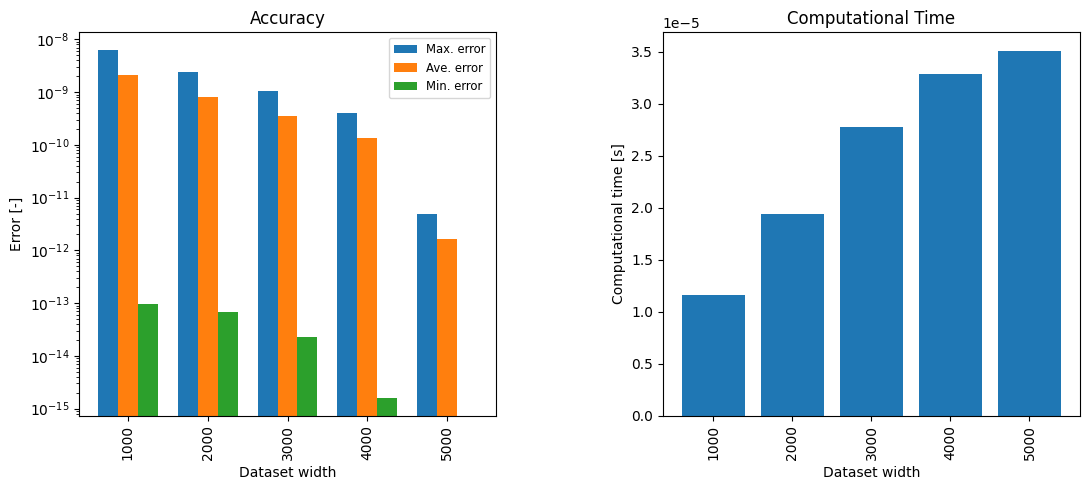

In [10]:
plot_table_evaluation(results_table, MATERIAL)

As expected, the largest dataset (5000 data) provides the best accuracy: the time effort is comparable with that required for managing smaller datasets. Then, this dataset will be hereafter used in the _TAB_ method. 

## Fitting polynomial
In this section, a polynomial is built fitting a dataset of 5000 temperature-enthalpy couples. The _NumPy_ functions `polyfit` and `polyval` are used. 

According to the `numpy.polyfit` documentation page (https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html), the polynomial coefficients' fitting may be badly conditioned when the degree of the polynomial is large. When this happens, a _RankWarning_ is issued.

Using data file: data/lead/lead_5000.csv
Evaluating polynomium degree 1...
Evaluating polynomium degree 2...
Evaluating polynomium degree 3...
Evaluating polynomium degree 4...
Evaluating polynomium degree 5...
Evaluating polynomium degree 6...
Evaluating polynomium degree 7...
Evaluating polynomium degree 8...
Evaluating polynomium degree 9...
Evaluating polynomium degree 10...
Evaluating polynomium degree 11...


/home/fpepe/programs/dassh_nc/enthalpy_to_temperature/time_and_accuracy.py:257: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/home/fpepe/programs/dassh_nc/enthalpy_to_temperature/time_and_accuracy.py:257: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)


Evaluating polynomium degree 12...
Evaluating polynomium degree 13...


/home/fpepe/programs/dassh_nc/enthalpy_to_temperature/time_and_accuracy.py:257: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/home/fpepe/programs/dassh_nc/enthalpy_to_temperature/time_and_accuracy.py:257: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)


Evaluating polynomium degree 14...
Evaluating polynomium degree 15...


/home/fpepe/programs/dassh_nc/enthalpy_to_temperature/time_and_accuracy.py:257: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/home/fpepe/programs/dassh_nc/enthalpy_to_temperature/time_and_accuracy.py:257: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)


Evaluating polynomium degree 16...
Evaluating polynomium degree 17...


/home/fpepe/programs/dassh_nc/enthalpy_to_temperature/time_and_accuracy.py:257: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/home/fpepe/programs/dassh_nc/enthalpy_to_temperature/time_and_accuracy.py:258: RankWarning: Polyfit may be poorly conditioned
  coeffs_h2T = np.polyfit(data[:,1], data[:,0], deg=dd)


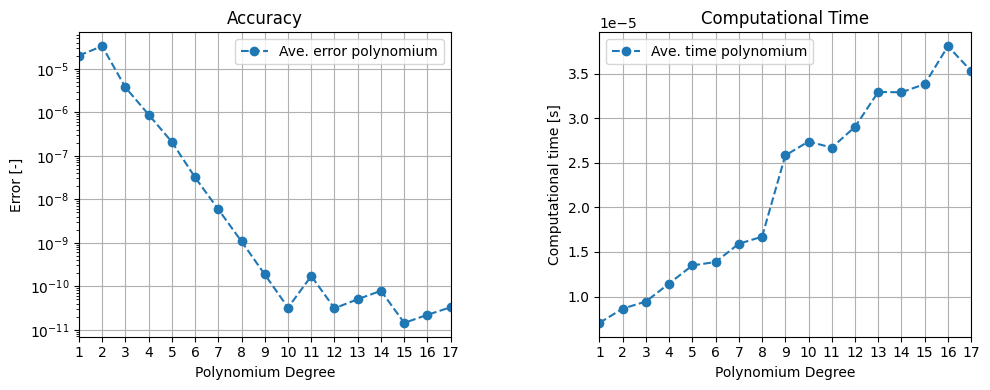

In [11]:
data_path = DB_PATH_PREFIX + str(DB_SIZES[MATERIAL][-1]) + DB_PATH_SUFFIX
data_path = os.path.join(DATA_FOLDER, data_path)
print(f"Using data file: {data_path}")
data = np.genfromtxt(data_path, delimiter=',')

poly_results = get_poly_results(reference, data)

plot_polynomium_results(poly_results, MATERIAL)

_NumPy_ issues a _RankWarning_ for polynomials of degree >= 11. As a consequence, the $10^{th}$ degree polynomial is hereafter considered as the most accurate and reliable.

## Time effort

The average time effort is estimated for all the considered methods. 

The calculations are performed considering an initial temperature of 700 K and an enthalpy rise of 100 J/kg.

For the _TAB_ and _POLY_ methods the largest dataset has been considered.

In [12]:

table = [["Newton", eval_time(newton_method, coolant=coolant)],
         ["lbh15", eval_time(lbh15_method, coolant=coolant)],
         ["Table", results_table[DB_SIZES[MATERIAL][-1]]['time']],
         ["Polynomium (10 deg)", poly_results['time_poly'][9]]]

print(tabulate(table, headers=["Method", "Computational effort [s]"], 
               tablefmt="github"))

| Method              |   Computational effort [s] |
|---------------------|----------------------------|
| Newton              |                0.000330933 |
| lbh15               |                0.0105184   |
| Table               |                3.5117e-05  |
| Polynomium (10 deg) |                2.73964e-05 |


## Accuracy evaluation

To estimate the accuracy of the _NEW_, _TAB_ and _POLY_ methods, a vector of $n$ temperatures `tt_ref` is created.

For each pair of consecutive elements in `tt_ref` ($T_i$ and $T_{i+1}$), the corresponding enthalpy rise $\Delta h(T_i, T_{i+1})$ is calculated with _lbh15_, producing a vector of $n-1$ enthalpy values `hh_ref`.

`tt_ref` and `hh_ref` vectors are passed as parameters to the three above-mentioned methods (see the code documentation in _temp_from_h.py_ to retrieve details on how they are used). The results are compared with the corresponding elements of `tt_ref`.

In the following code snippet, the accuracy of the methods is evaluated against the 5000-point dataset already used as reference in the _TAB method analysis_ section. 

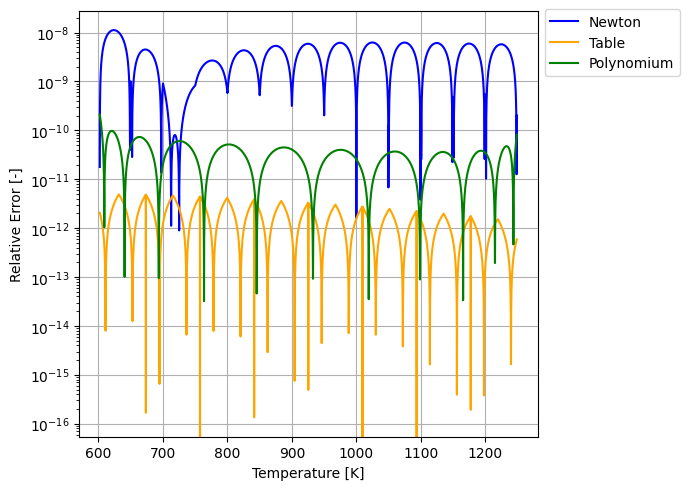

In [6]:
err_newton = eval_accuracy(newton_method, reference, coolant=coolant)
err_table = eval_accuracy(table_method, reference, data_path=data_path)
err_poly = eval_accuracy(poly_method, reference, 
                           coeffs_T2h=np.polyfit(data[:,0], data[:,1], deg=10), 
                           coeffs_h2T=np.polyfit(data[:,1], data[:,0], deg=10))
plot_accuracy_comparison(reference, err_newton, err_table, err_poly, MATERIAL)

# Conclusions

The following methods for converting enthalpy to temperature were compared: _NEW_, _lbh15_, _TAB_ (based on the _NumPy_ function `interp`), and _POLY_ (based on the _NumPy_ functions `polyfit` and `polyval`). Both time effort and accuracy were evaluated.

Accuracy was assessed against a reference dataset of 5000 points calculated using _lbh15_.

_NEW_ and _lbh15_ methods are the most computationally expensive. In addition, _TAB_ and _POLY_ provide the greatest accuracy (particularly when compared to _NEW_ method).

Although _TAB_ is slightly more accurate than _POLY_ (with maximum errors of the order of $10^{-12}$ and $10^{-10}$, respectively), the latter is slightly faster. Considering the _POLY_ method accurate enough, it is chosen to be implemented.